# Supplementary Note on Genomic DNA analysis

I would like for this one to be fully runnable. I will deposit the necessary files alongside submission. This will include 
1. The meta DNA file
2. the allele table - zipped
3. Other modality data -PTENplots

## Loading Data and importing CRISPResso outputs

In [52]:
#Loading the standard set of packages used for this analysis
suppressPackageStartupMessages({
    library(MASS)
    library(gdata)
    library(singlecellmethods)
    library(matrixStats)
    library(data.table)
    library(viridis)
    #library(seaborn)
    library(RColorBrewer)
    library(pheatmap)
    library(Matrix)
    library(harmony)
    library(uwot)
    library(irlba)
    library(Seurat)
    library(factoextra)
    library(presto) 
    library(tidyverse)
    library(Biostrings)
    library(ggpubr)
    library(ggridges)
    library(ggrepel)
})


In [2]:
#Pulling allele table files location. 
DNAfiles = "/Users/bagtq9/Desktop/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/2023-04-03 PTEN-DQB1-FBXO11/Alleles"

In [3]:
#importing DNA meta data for determining plate barcodes
meta_DNA <- read_csv("2023-04-03 PTEN-DQB1-FBXO11/Analysis/DNAMeta.csv")

Rows: 10 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): PlateLabel, MainCondition, Barcode_DNA, Reference

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
#Let's take a quick look at what this file looks like. 
head(meta_DNA)

PlateLabel,MainCondition,Barcode_DNA,Reference
<chr>,<chr>,<chr>,<chr>
JDHEK_P1,JDHEK,CGCTCAGTTC,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
JDHEK_P2,JDHEK,TATCTGACCT,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
FBXO11_P1,FBXO11,ATATGAGACG,CTAGCACTCCATGTCCATTGTCATAAAAATAAACACCAACCTAAAATTTAAAAAAAAAAAAAAAGCTTTTTCAAGGGACAAGTATTTACAAAACAATGTATTTCCCATCCAAGAGTCCAGGCTAATCCTACCTGCTTGCCACTGTGTATCCGGTTTCTTCTCAGTACTGGAG
FBXO11_P2,FBXO11,CTTATGGAAT,CTAGCACTCCATGTCCATTGTCATAAAAATAAACACCAACCTAAAATTTAAAAAAAAAAAAAAAGCTTTTTCAAGGGACAAGTATTTACAAAACAATGTATTTCCCATCCAAGAGTCCAGGCTAATCCTACCTGCTTGCCACTGTGTATCCGGTTTCTTCTCAGTACTGGAG
FBXO11_P3,FBXO11,TAATCTCGTC,CTAGCACTCCATGTCCATTGTCATAAAAATAAACACCAACCTAAAATTTAAAAAAAAAAAAAAAGCTTTTTCAAGGGACAAGTATTTACAAAACAATGTATTTCCCATCCAAGAGTCCAGGCTAATCCTACCTGCTTGCCACTGTGTATCCGGTTTCTTCTCAGTACTGGAG
FBXO11_P4,FBXO11,GCGCGATGTT,CTAGCACTCCATGTCCATTGTCATAAAAATAAACACCAACCTAAAATTTAAAAAAAAAAAAAAAGCTTTTTCAAGGGACAAGTATTTACAAAACAATGTATTTCCCATCCAAGAGTCCAGGCTAATCCTACCTGCTTGCCACTGTGTATCCGGTTTCTTCTCAGTACTGGAG


In [5]:
#Importing all Allele tables generated by CRISPResso - This takes a while. In the future I recommend pre-filtering on 10 rows to save time and space. 
files <- list.files(path = DNAfiles, pattern = ".txt$", full.names = T, 
        recursive = T) #List the files 
matrix <- suppressMessages({
        suppressWarnings({
            lapply(files, read_tsv)
        })
    }) #batch import into a list
names(matrix) <- paste0(str_split(files, pattern = "on_|/", 
        simplify = T)[, c(13)], "_", str_split(files, pattern = "on_|/", 
        simplify = T)[, c(17)]) #Name each list item as the cell

matrix <- bind_rows(matrix, .id = "Plate_Well") #collapse it all down

In [6]:
#save a copy of this matrix for manipulation. 
alleles_DNA<- matrix
# merge with meta data to have a unique plate and cell ID consistent with all the other data
alleles_DNA<-alleles_DNA %>% separate(Plate_Well, into = c("Barcode_DNA", "Well_ID")) %>% inner_join(meta_DNA) 

Joining with `by = join_by(Barcode_DNA)`


In [7]:
#Filter on only the mixed cell lines experiment. 
PTEN_alleles_DNA <- filter(alleles_DNA, MainCondition == "JDHEK")

In [8]:
#Take a quick look at this table. 
PTEN_alleles_DNA %>% head

Barcode_DNA,Well_ID,Aligned_Sequence,Reference_Sequence,Reference_Name,Read_Status,n_deleted,n_inserted,n_mutated,#Reads,%Reads,PlateLabel,MainCondition,Reference
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
CGCTCAGTTC,A1,------------------------------------------------------GTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,Reference,UNMODIFIED,0,0,0,247,66.3978495,JDHEK_P1,JDHEK,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
CGCTCAGTTC,A1,-------------------------------------------------------------GCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGGGCCCATGGGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGAC-------GGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,Reference,UNMODIFIED,0,0,0,22,5.9139785,JDHEK_P1,JDHEK,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
CGCTCAGTTC,A1,------------------------------------------------------GTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCATGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,Reference,UNMODIFIED,0,0,0,11,2.9569892,JDHEK_P1,JDHEK,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
CGCTCAGTTC,A1,--------------------------------------TCAGGACCCACACG------------------ACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCCTG------AAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAA-TTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCC-------GTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,Reference,MODIFIED,0,1,1,10,2.6881720,JDHEK_P1,JDHEK,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
CGCTCAGTTC,A1,------------------------------------------------------GTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGCTTGTACTTTACTTTCATTGGGA,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,Reference,UNMODIFIED,0,0,0,7,1.8817204,JDHEK_P1,JDHEK,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTC

In [9]:
# exported for replication
PTEN_alleles_DNA %>% write_csv("PTEN_alleles_full.csv")

In [10]:
#Create a plate_well ID for easy cell identification by combining the barcode DNA with the well_ID
PTEN_alleles_DNA <- PTEN_alleles_DNA %>% mutate(plate_well = paste0(Barcode_DNA, Well_ID))
#Group by this ID to create a grouped table. 
PTEN_alleles_DNA<- PTEN_alleles_DNA%>% group_by(plate_well)

#Add the total # of reads per cell in a a new columbn for filtering. Future iterations of this analysis will simply multiply % of total * the number. 
PTEN_alleles_DNA<- PTEN_alleles_DNA %>% summarize("TotalReads"=sum(`#Reads`)) %>% inner_join(PTEN_alleles_DNA)

Joining with `by = join_by(plate_well)`


In [11]:
#Let's take a quick look 
head(PTEN_alleles_DNA)

plate_well,TotalReads,Barcode_DNA,Well_ID,Aligned_Sequence,Reference_Sequence,Reference_Name,Read_Status,n_deleted,n_inserted,n_mutated,#Reads,%Reads,PlateLabel,MainCondition,Reference
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
CGCTCAGTTCA1,372,CGCTCAGTTC,A1,------------------------------------------------------GTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,Reference,UNMODIFIED,0,0,0,247,66.3978495,JDHEK_P1,JDHEK,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
CGCTCAGTTCA1,372,CGCTCAGTTC,A1,-------------------------------------------------------------GCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGGGCCCATGGGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGAC-------GGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,Reference,UNMODIFIED,0,0,0,22,5.9139785,JDHEK_P1,JDHEK,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
CGCTCAGTTCA1,372,CGCTCAGTTC,A1,------------------------------------------------------GTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCATGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,Reference,UNMODIFIED,0,0,0,11,2.9569892,JDHEK_P1,JDHEK,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
CGCTCAGTTCA1,372,CGCTCAGTTC,A1,--------------------------------------TCAGGACCCACACG------------------ACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCCTG------AAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAA-TTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCC-------GTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,Reference,MODIFIED,0,1,1,10,2.6881720,JDHEK_P1,JDHEK,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA
CGCTCAGTTCA1,372,CGCTCAGTTC,A1,------------------------------------------------------GTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGCTTGTACTTTACTTTCATTGGGA,GCATTTCCTGTGAAATAATACTGGTATGTATTTAACCATGCAGATCCTCAGTTTGTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA,Reference,UNMODIFIED,0,0

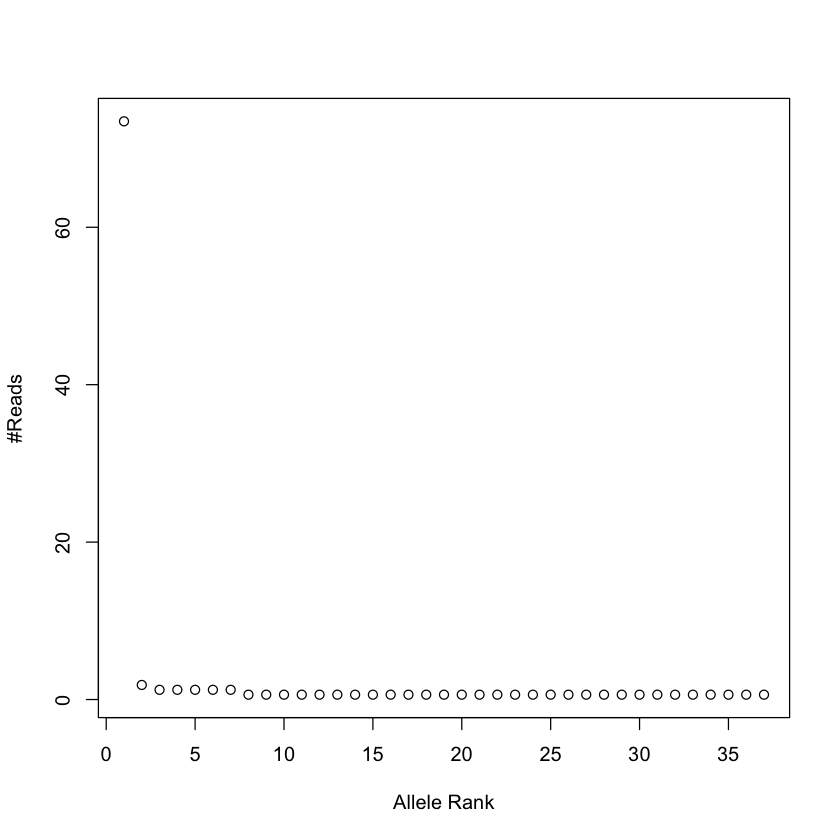

In [12]:
#Let's use this table to take a quick look at a random cell. The % of reads per allele is ploted. This shows a clearly that one allele has dominanted. 
PTEN_alleles_DNA %>% filter(plate_well == "TATCTGACCTD1") %>% with(`%Reads`) %>% plot(ylab = "#Reads", xlab = "Allele Rank")

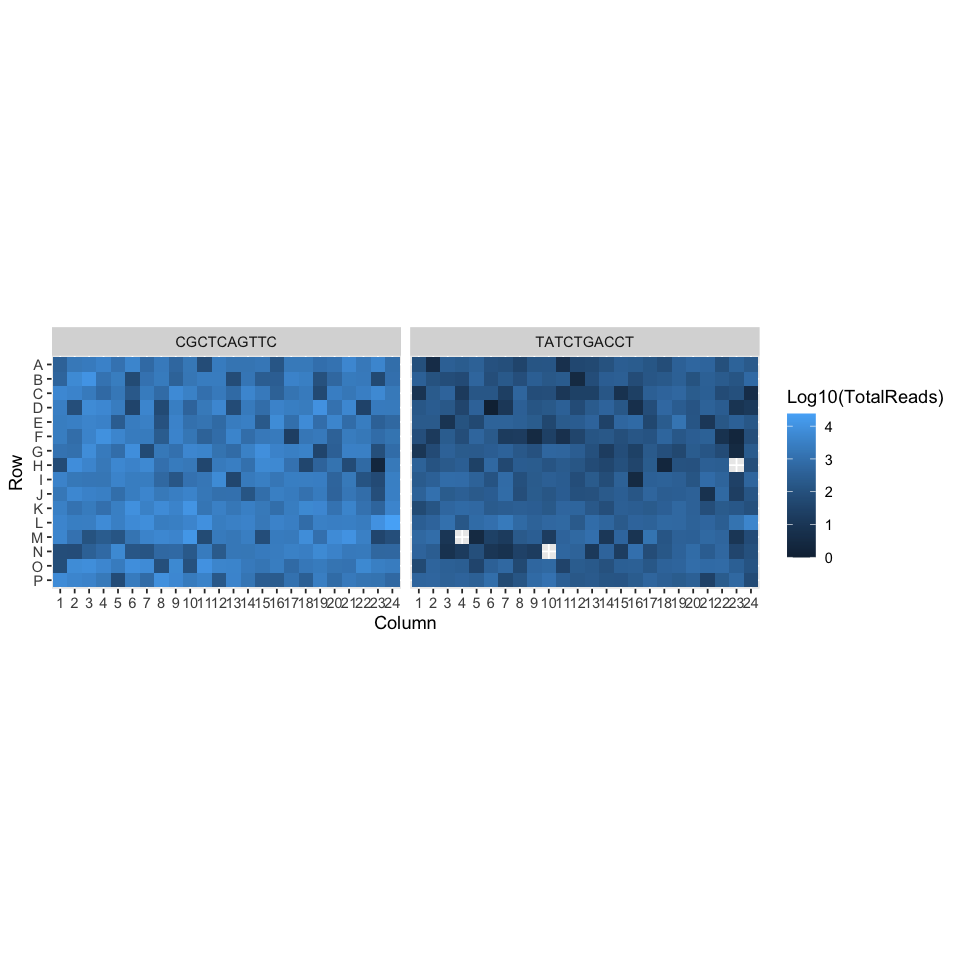

In [56]:
#Let's plot this by physical location. The total number of reads
fig.size(8,8)
PTEN_alleles_DNA %>% separate(Well_ID, 
                        into = c("Row", "Column"), 
                        sep = "(?<=[A-Za-z])(?=[0-9])") %>% 
    mutate("Column" = factor(Column, levels = c(1:24))) %>%
    mutate("Row"= factor(Row, levels = c(LETTERS[26:1]))) %>% 
    na.omit %>% 
    
ggplot(aes(x = Column, y = Row)) + geom_tile(aes(fill = log10(TotalReads))) + facet_wrap(~Barcode_DNA) + 
    #scale_fill_brewer(palette = "Set2") + theme_gy(10) + 
    theme(aspect.ratio = 16/24) + labs(fill = "Log10(TotalReads)")

## Filtering on total number of read

In [17]:
source("DNA_filtering_Functions.R") # this has the fig.size function

In [57]:
fig.size(5,5)
## Function for Read Filtering per cell
# A function for filtering 
# Going to calculate total reads per cell then separate by plate and then define cutoffs with splines. 
Filtering_Cells_Read <- function(x){ 
mat <- mutate(x, plate_well =  paste0(Barcode_DNA, Well_ID)) # add platt_well id. The input are allele tables output and combined from CRISPEsso (keeping the top 10)
mat <- mutate(mat, TotalReads = `#Reads`/(`%Reads`/100))# Calculate total reads
Plates <- unique(mat$Barcode_DNA) # Define the plate
 
#To plate we will now identify plate cutoffs of total reads based on ranking. 
ReadFilters <- 
    lapply(Plates, 
    function(Plate){
    data <- mat %>% filter(Barcode_DNA == Plate) %>% group_by(plate_well) %>% top_n(1, wt = `#Reads`) %>% select(TotalReads, plate_well) %>% unique #Total reads per cell are extracted. 
    totals <-data$TotalReads #This data is defined
    o <- order(totals, decreasing = T) # find the order
    stuff <- rle(totals[o]) # handling ties
    run.totals <- stuff$values # pull out values
    run.rank <- cumsum(stuff$lengths) - (stuff$lengths-1)/2 # Get mid-rank of each run.

    y <- log10(run.totals) #Define y as log10 transformed reads / cell
    x <- (run.rank) # Rank with ties

    fit <- smooth.spline(x, y, df=5) # Fit a spline with 5 degrees of freedom. Have tested more - up to 20. Leads to instability. 
    d1 <- predict(fit, deriv=1)$y #first derivative 
    d2 <- predict(fit, deriv=2)$y #second derivative
    curvature <- d2/(1 + d1^2)^1.5 # predict curvature - This is from the Empty Droplets Algorithm paper. 
    
    #Plot curvature and cutoff. 
    print(ggplot(data = tibble(x = 1:length(curvature), y=curvature), aes(x,y)) + geom_point()+ xlab("Rank") + ylab("Calculated Curvature") + theme_gy() + 
          theme(axis.text.x = element_text(hjust = 0.75)) + ggtitle(Plate) + 
          geom_vline(xintercept = which.min(curvature),linetype= "dashed", color = "red", size = 1)) # A graph of the total reads with cutoff labelled, sanity check.  
    
    #A graph of the total reads with cutoff labelled, sanity check. 
    print(ggplot(data = tibble(x,y), aes(x,y)) + geom_point()+ xlab("Rank") + ylab("log10(Reads) \n per cell") + theme_gy() + theme(axis.text.x = element_text(hjust = 0.75)) + ggtitle(Plate) + 
        geom_hline(yintercept = y[which.min(curvature)],linetype= "dashed", color = "red", size = 1))
    
    return(cutoff = 10^y[which.min(curvature)]) # store this cutoff
    })
    names(ReadFilters) <- Plates # add plate name

    #Filter plates and return combined tibble. 
return(
    bind_rows(lapply(Plates, function(x){
    filter(mat, Barcode_DNA == x & TotalReads > ReadFilters[x])})))
    }


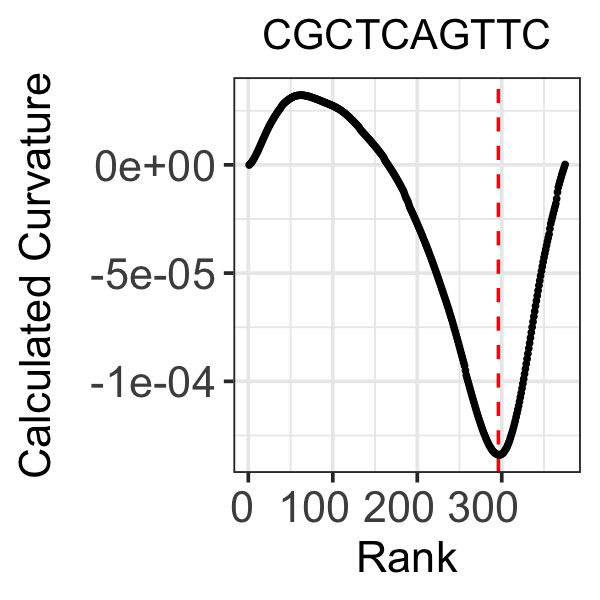

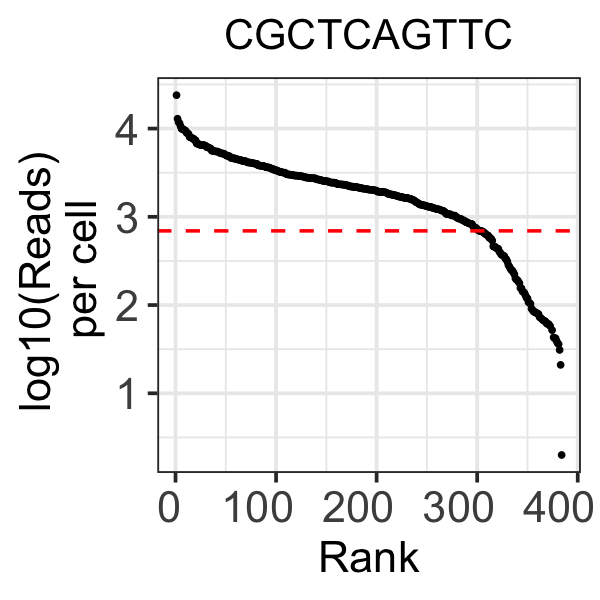

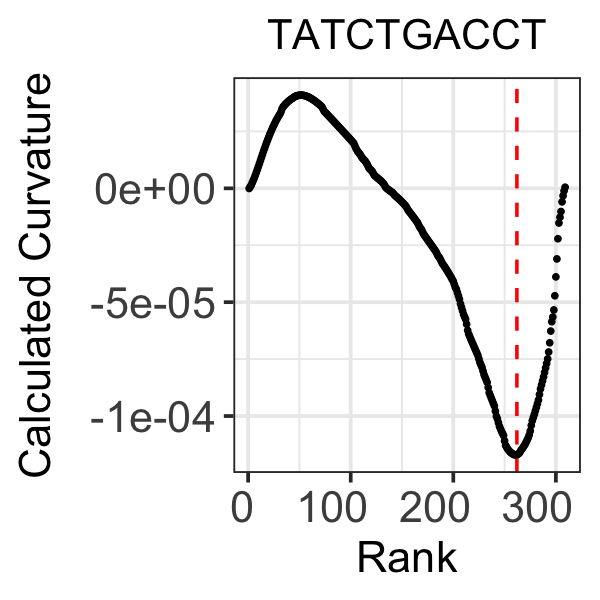

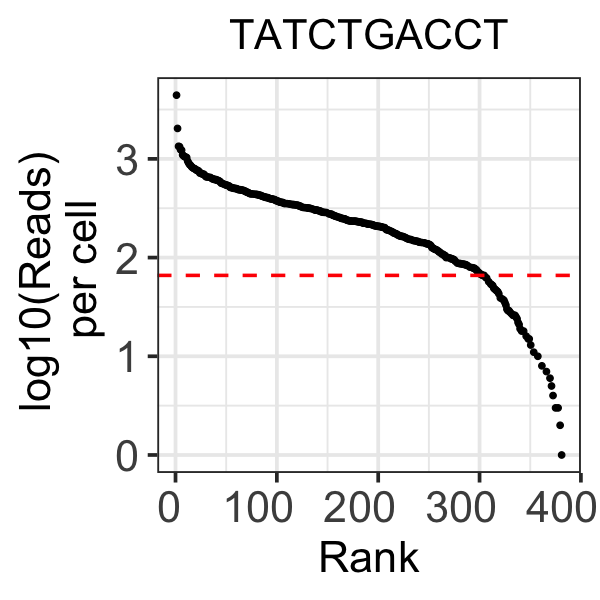

In [58]:
PTENp1_filtered <- Filtering_Cells_Read(PTEN_alleles_DNA)

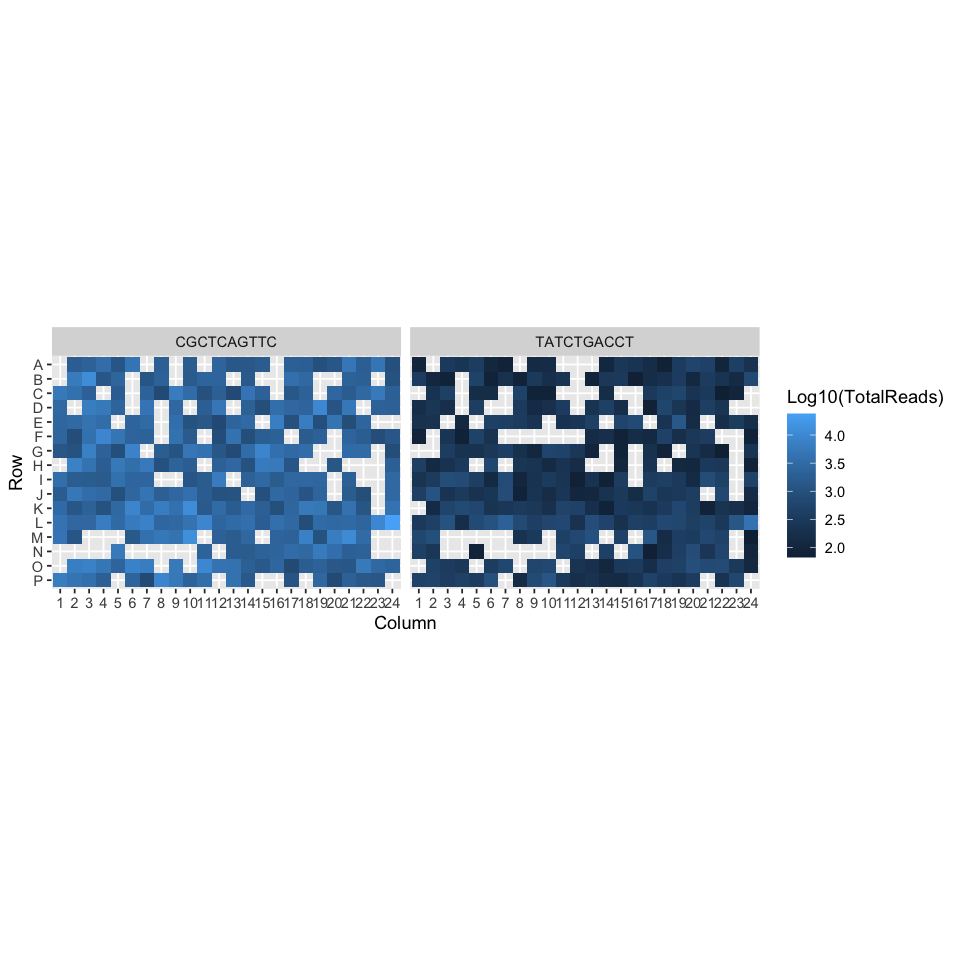

In [59]:
# Plot to see if they are all clustering together somehow
fig.size(8,8)
PTENp1_filtered %>% separate(Well_ID, 
                        into = c("Row", "Column"), 
                        sep = "(?<=[A-Za-z])(?=[0-9])") %>% 
    mutate("Column" = factor(Column, levels = c(1:24))) %>%
    mutate("Row"= factor(Row, levels = c(LETTERS[26:1]))) %>% 
    na.omit %>% 
    
ggplot(aes(x = Column, y = Row)) + geom_tile(aes(fill = log10(TotalReads))) + facet_wrap(~Barcode_DNA) + 
    #theme_gy(10) + 
    theme(aspect.ratio = 16/24) + labs(fill = "Log10(TotalReads)")

## Filtering Alleles on a per cell level

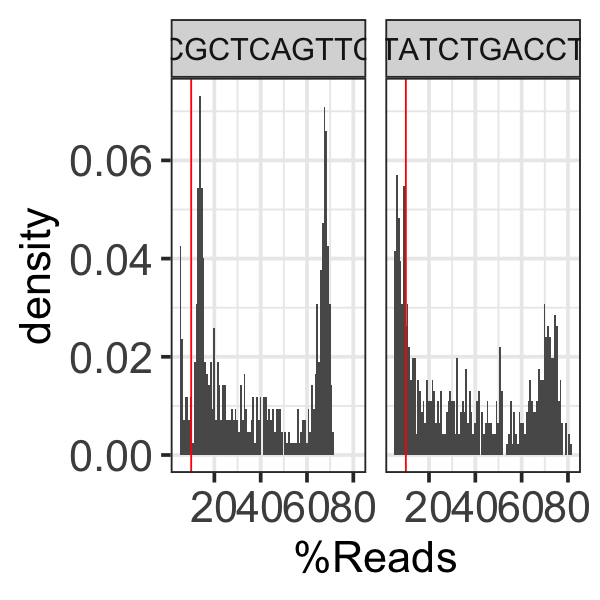

In [60]:
fig.size(5,5)
PTENp1_filtered %>% filter(`%Reads` > 5) %>% add_count(Aligned_Sequence) %>% filter(n > 10) %>% arrange(n)%>% 
ggplot(aes(`%Reads`)) + 
geom_histogram(aes(y = ..density..),bins = 100) + theme_gy() + geom_vline(xintercept = 10, color = "red") + 
facet_grid(~Barcode_DNA)

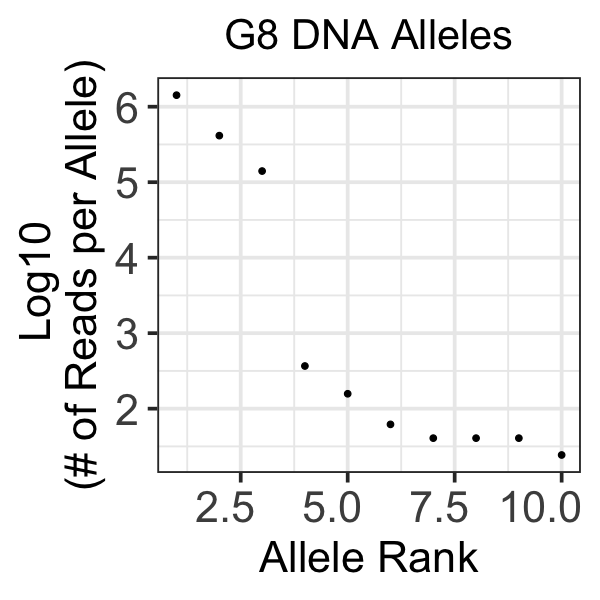

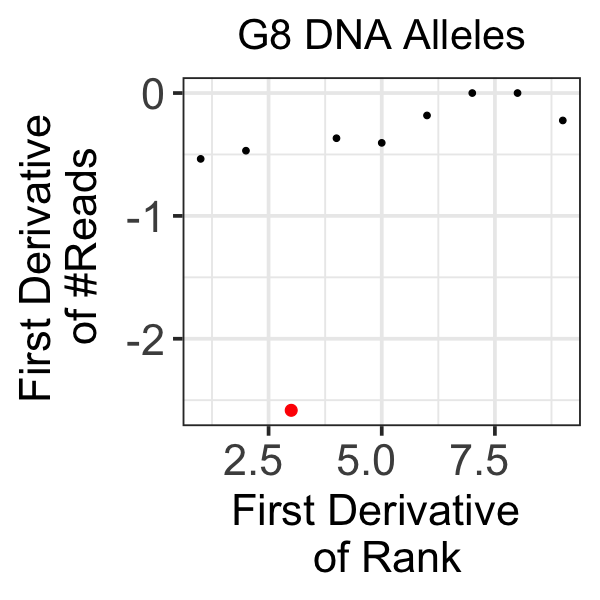

In [61]:
#Okay let's think about how to best filter on the alleles now. The low quality cells have been removed. Let's now call the genotypes
#First a look at # or reads per allele in a random cell
cell <- "CGCTCAGTTCA5"

fig.size(5,5)
PTENp1_filtered %>% filter(plate_well == cell) %>% head(10) %>% { 
    ggplot(data = ., aes(1:dim(.)[1], log(`#Reads`)))
    } + geom_point() + theme_gy() + xlab("Allele Rank") + ggtitle(cell) + ylab("Log10 \n(# of Reads per Allele)") + theme(axis.text.x = element_text(hjust =0.75))+ ggtitle("G8 DNA Alleles")

#First derivative. 
y<- PTENp1_filtered %>% filter(plate_well ==cell) %>% head(10) %>% with(`#Reads`)  %>% log %>% diff 
x <- 1:length(y)


ggplot(data = tibble(x,y), aes(x,y)) + geom_point() + theme_gy() + xlab("First Derivative \n of Rank") + ggtitle("G8 DNA Alleles") + ylab("First Derivative \n of #Reads") + 
theme(axis.text.x = element_text(hjust =0.75)) + geom_point(data = tibble(x,y)[which.min(y),], color= "red", size = 3) # +ggtitle(cell)

In [62]:
# A function for peforming this per cell based filtering. input in the tibble generated after filtering cells by total reads. 
Filtering_Alleles_Percentage <- function (x, cutoff = 10) 
{
    matrix <- x
    matrix <- mutate(matrix, plate_well = paste0(Barcode_DNA, 
        Well_ID))
    cells <- unique(matrix$plate_well)
    Plates <- unique(matrix$Barcode_DNA)
    Allele_Threshold <- lapply(cells, function(x) {
        data <- matrix %>% filter(plate_well == x) %>% dplyr::select(`%Reads`)
        totals <- data$`%Reads`
        o <- order(totals, decreasing = T)
        stuff <- rle(totals[o])
        run.totals <- stuff$value
        run.rank <- cumsum(stuff$lengths) - (stuff$lengths - 
            1)/2
        y <- log10(run.totals)
        x <- (run.rank)
        return(which.min(diff(y)/diff(x)))
    })
    names(Allele_Threshold) <- cells
    Allele_Threshold <- lapply(Allele_Threshold, function(x) ifelse(length(x) == 
        0, 1, x))
    Filter_matrix <- bind_rows(lapply(cells, function(x) {
        if ((Allele_Threshold[x] > 0) == T) {
            dplyr::filter(matrix, plate_well == x) %>% top_n(n = Allele_Threshold[x], 
                wt = `%Reads`)
        }
        else {
            dplyr::filter(matrix, plate_well == x) %>% top_n(n = 1, 
                wt = `%Reads`)
        }
    }))
    Filter_matrix <- dplyr::filter(Filter_matrix, `%Reads` >= 
        cutoff)
    return(Filter_matrix)
}

In [63]:
PTENp1_filtered <- Filtering_Alleles_Percentage(PTENp1_filtered) # filter alleles

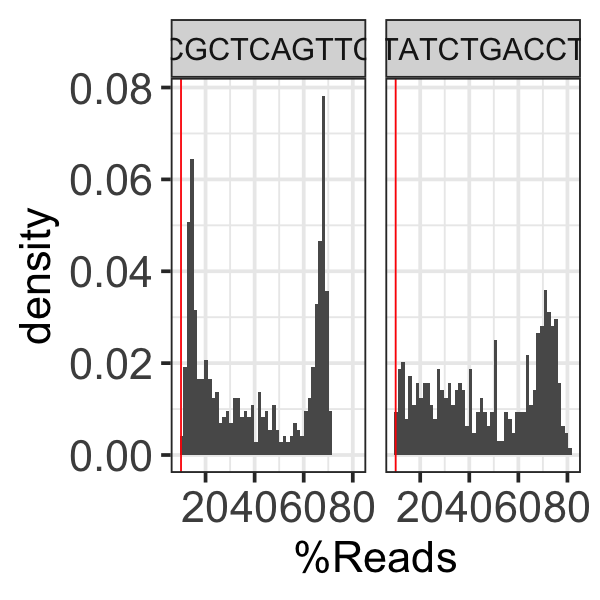

In [64]:
fig.size(5,5)
PTENp1_filtered %>% ggplot(aes(`%Reads`)) + 
geom_histogram(aes(y = ..density..),bins = 50) + theme_gy() + geom_vline(xintercept = 10, color = "red") + 
facet_grid(~Barcode_DNA)


## Realigning and trimming alleles for visualization

In [33]:
### Why does the DNA alignment not detect the indels ? Because its an insertion not a deletion
### That makes our visualization difficult. I need to align and introduce it myself. 
### Fix this with Biostrings. 
### Define an all encompasing reference sequence with indels present. 

PTENindelseq <- "GTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGGGCCCATGGGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA"

In [34]:
PTENp1_filtered_2_align <- mutate(PTENp1_filtered, "Reference" = PTENindelseq)
#Replace all special characters
PTENp1_filtered_2_align <- mutate(PTENp1_filtered_2_align, "Aligned_Sequence" = 
                                 str_replace_all(Aligned_Sequence, pattern = "-", replace = ""))
#Perform biostrings alignment
PTENp1_filtered_2_align <- mutate(PTENp1_filtered_2_align, "Aligned_Sequence" = as.character(alignedPattern
                                                               (pairwiseAlignment(Aligned_Sequence, Reference))))

In [35]:
#Trim length for visualization and plotting
PTENp1_filtered_2_align<- 
    mutate(PTENp1_filtered_2_align, 
           "Aligned_Sequence" = str_trunc(Aligned_Sequence, 180, "left", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 180, "left", ellipsis = ""))%>% 
    mutate("Aligned_Sequence" = str_trunc(Aligned_Sequence, 100, "right", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 100, "right", ellipsis = ""))

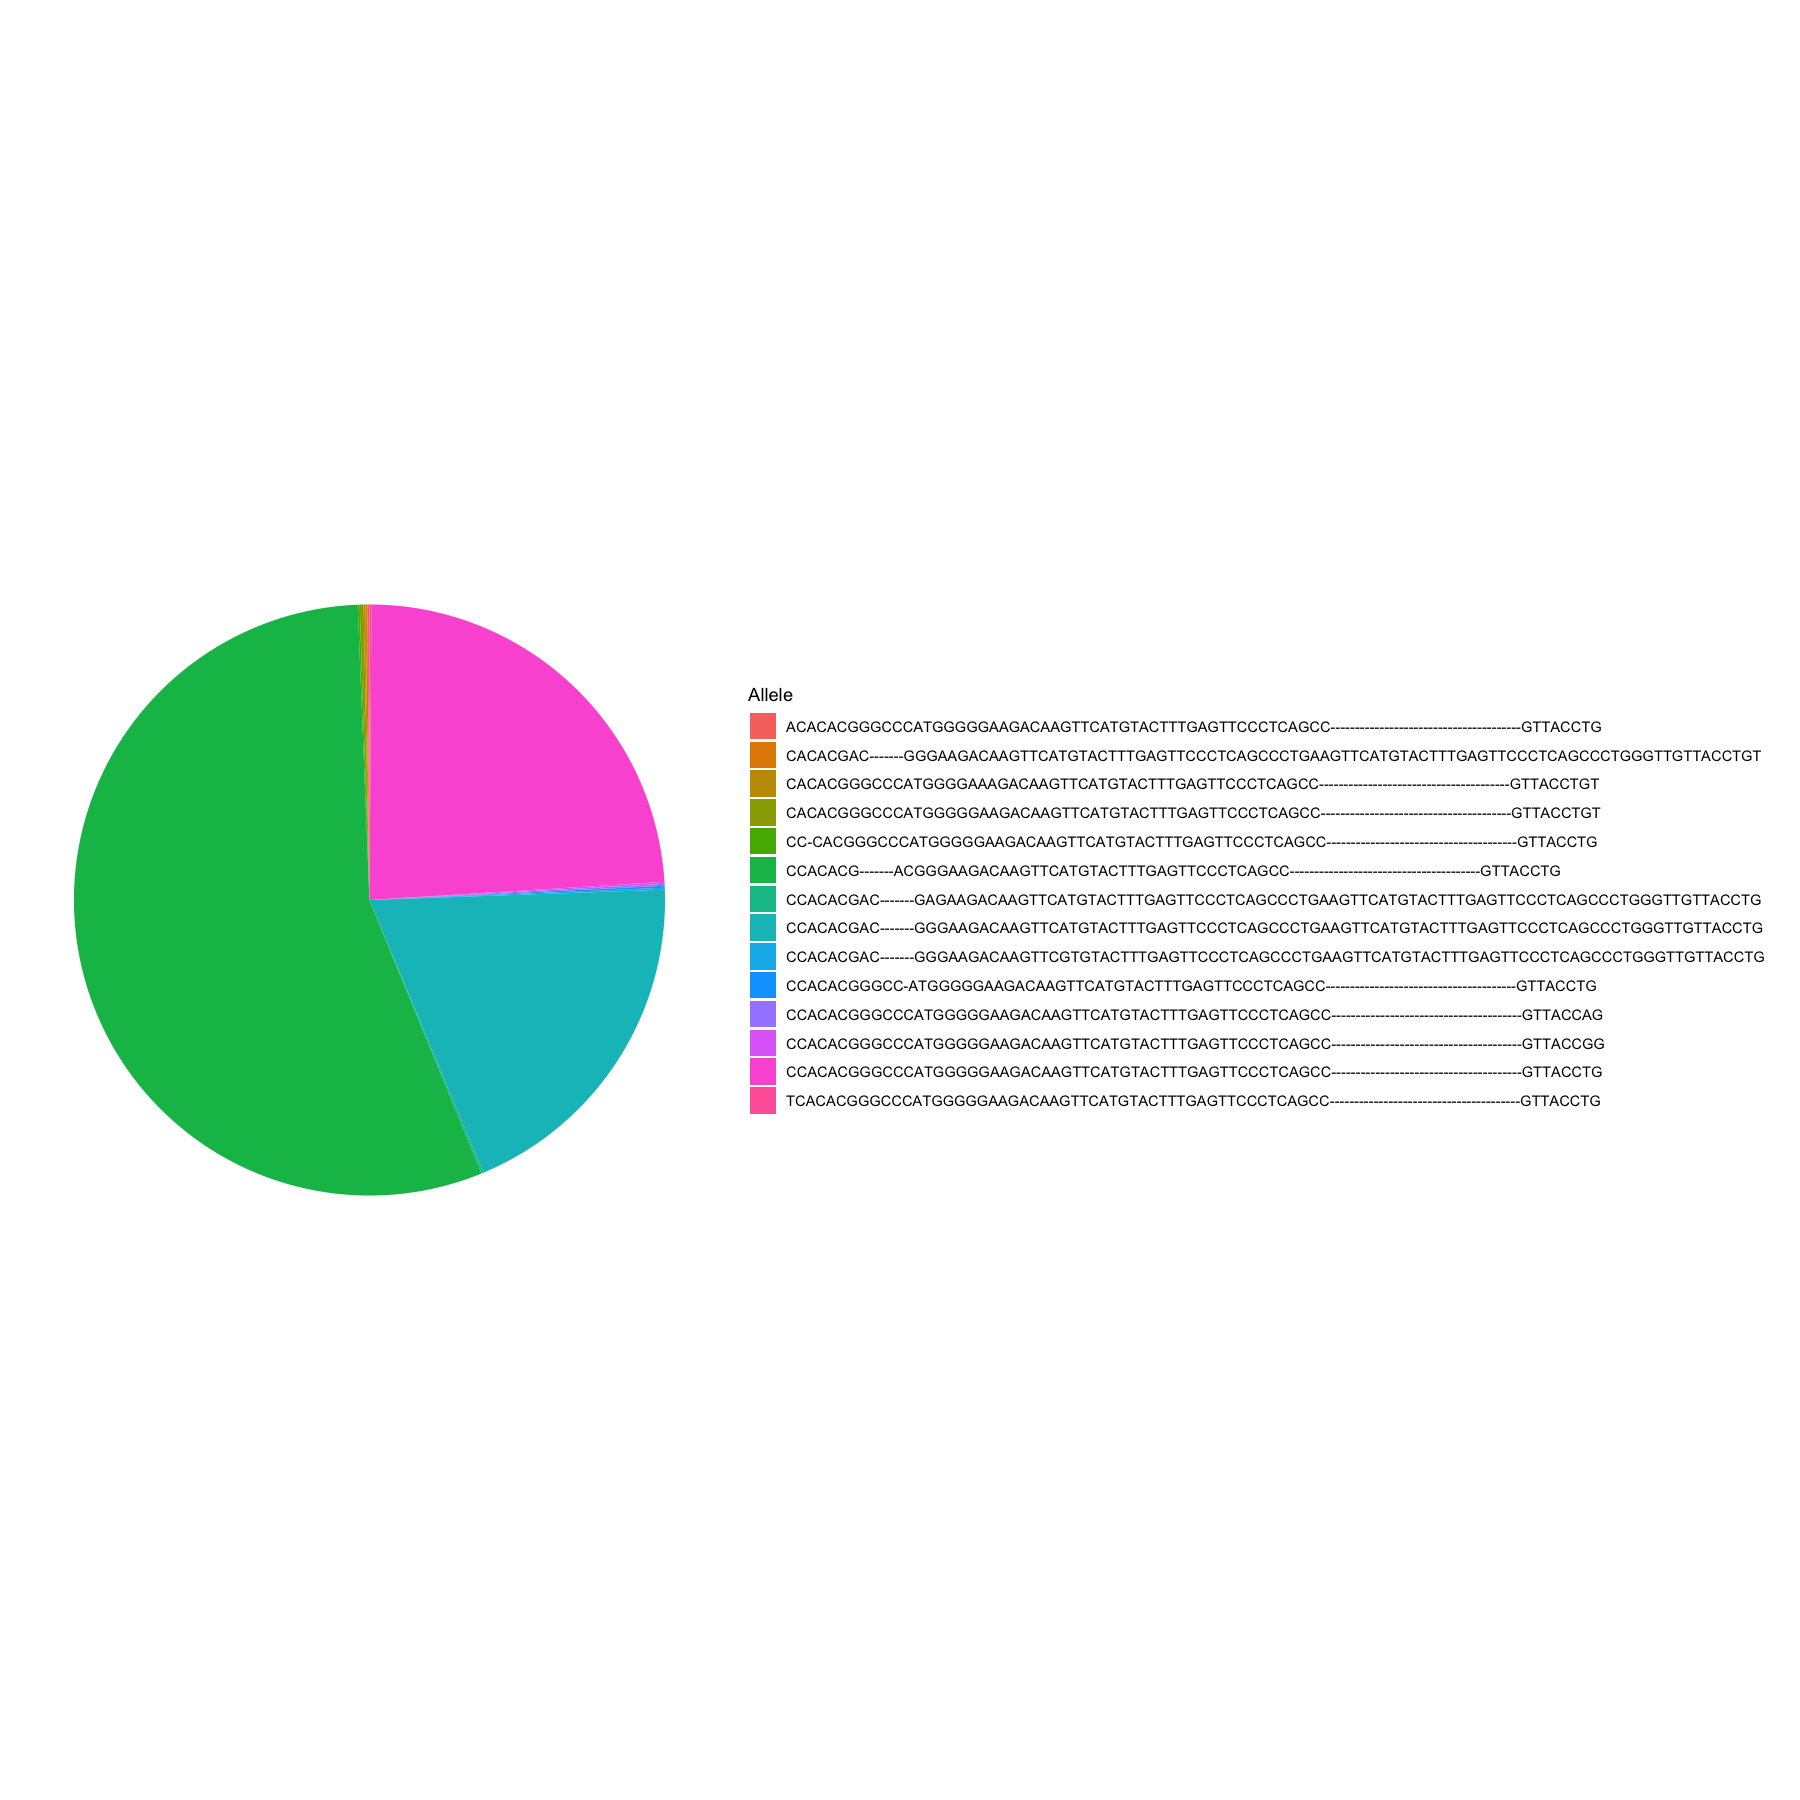

In [36]:
#Let's look at all these alleles. 
fig.size(15,15)
PTENp1_filtered_2_align$Aligned_Sequence %>% table %>% as_tibble() %>% ggplot(aes(x="", y=`n`, fill=as.factor(`.`))) +
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0) + theme_void() + labs(fill = "Allele")

In [37]:
PTENp1_filtered_2_align$Aligned_Sequence %>% table %>% as_tibble()

.,n
<chr>,<int>
ACACACGGGCCCATGGGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCC---------------------------------------GTTACCTG,1
CACACGAC-------GGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTGT,1
CACACGGGCCCATGGGGAAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCC---------------------------------------GTTACCTGT,1
CACACGGGCCCATGGGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCC---------------------------------------GTTACCTGT,2
CC-CACGGGCCCATGGGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCC---------------------------------------GTTACCTG,1
CCACACG-------ACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCC---------------------------------------GTTACCTG,525
CCACACGAC-------GAGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTG,1
CCACACGAC-------GGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTG,182
CCACACGAC-------GGGAAGACAAGTTCGTGTACTTTGAGTTCCCTCAGCCCTGAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTG,1


In [38]:
#Filter on at least 5 cells having the allele to remove noisy alleles caused by PCR errors. 
PTENp1_filtered_3_align <- PTENp1_filtered_2_align %>% ungroup %>% add_count(Aligned_Sequence) #Ungroup and add count
PTENp1_filtered_3_align <- filter(PTENp1_filtered_3_align, n > 5) # filter

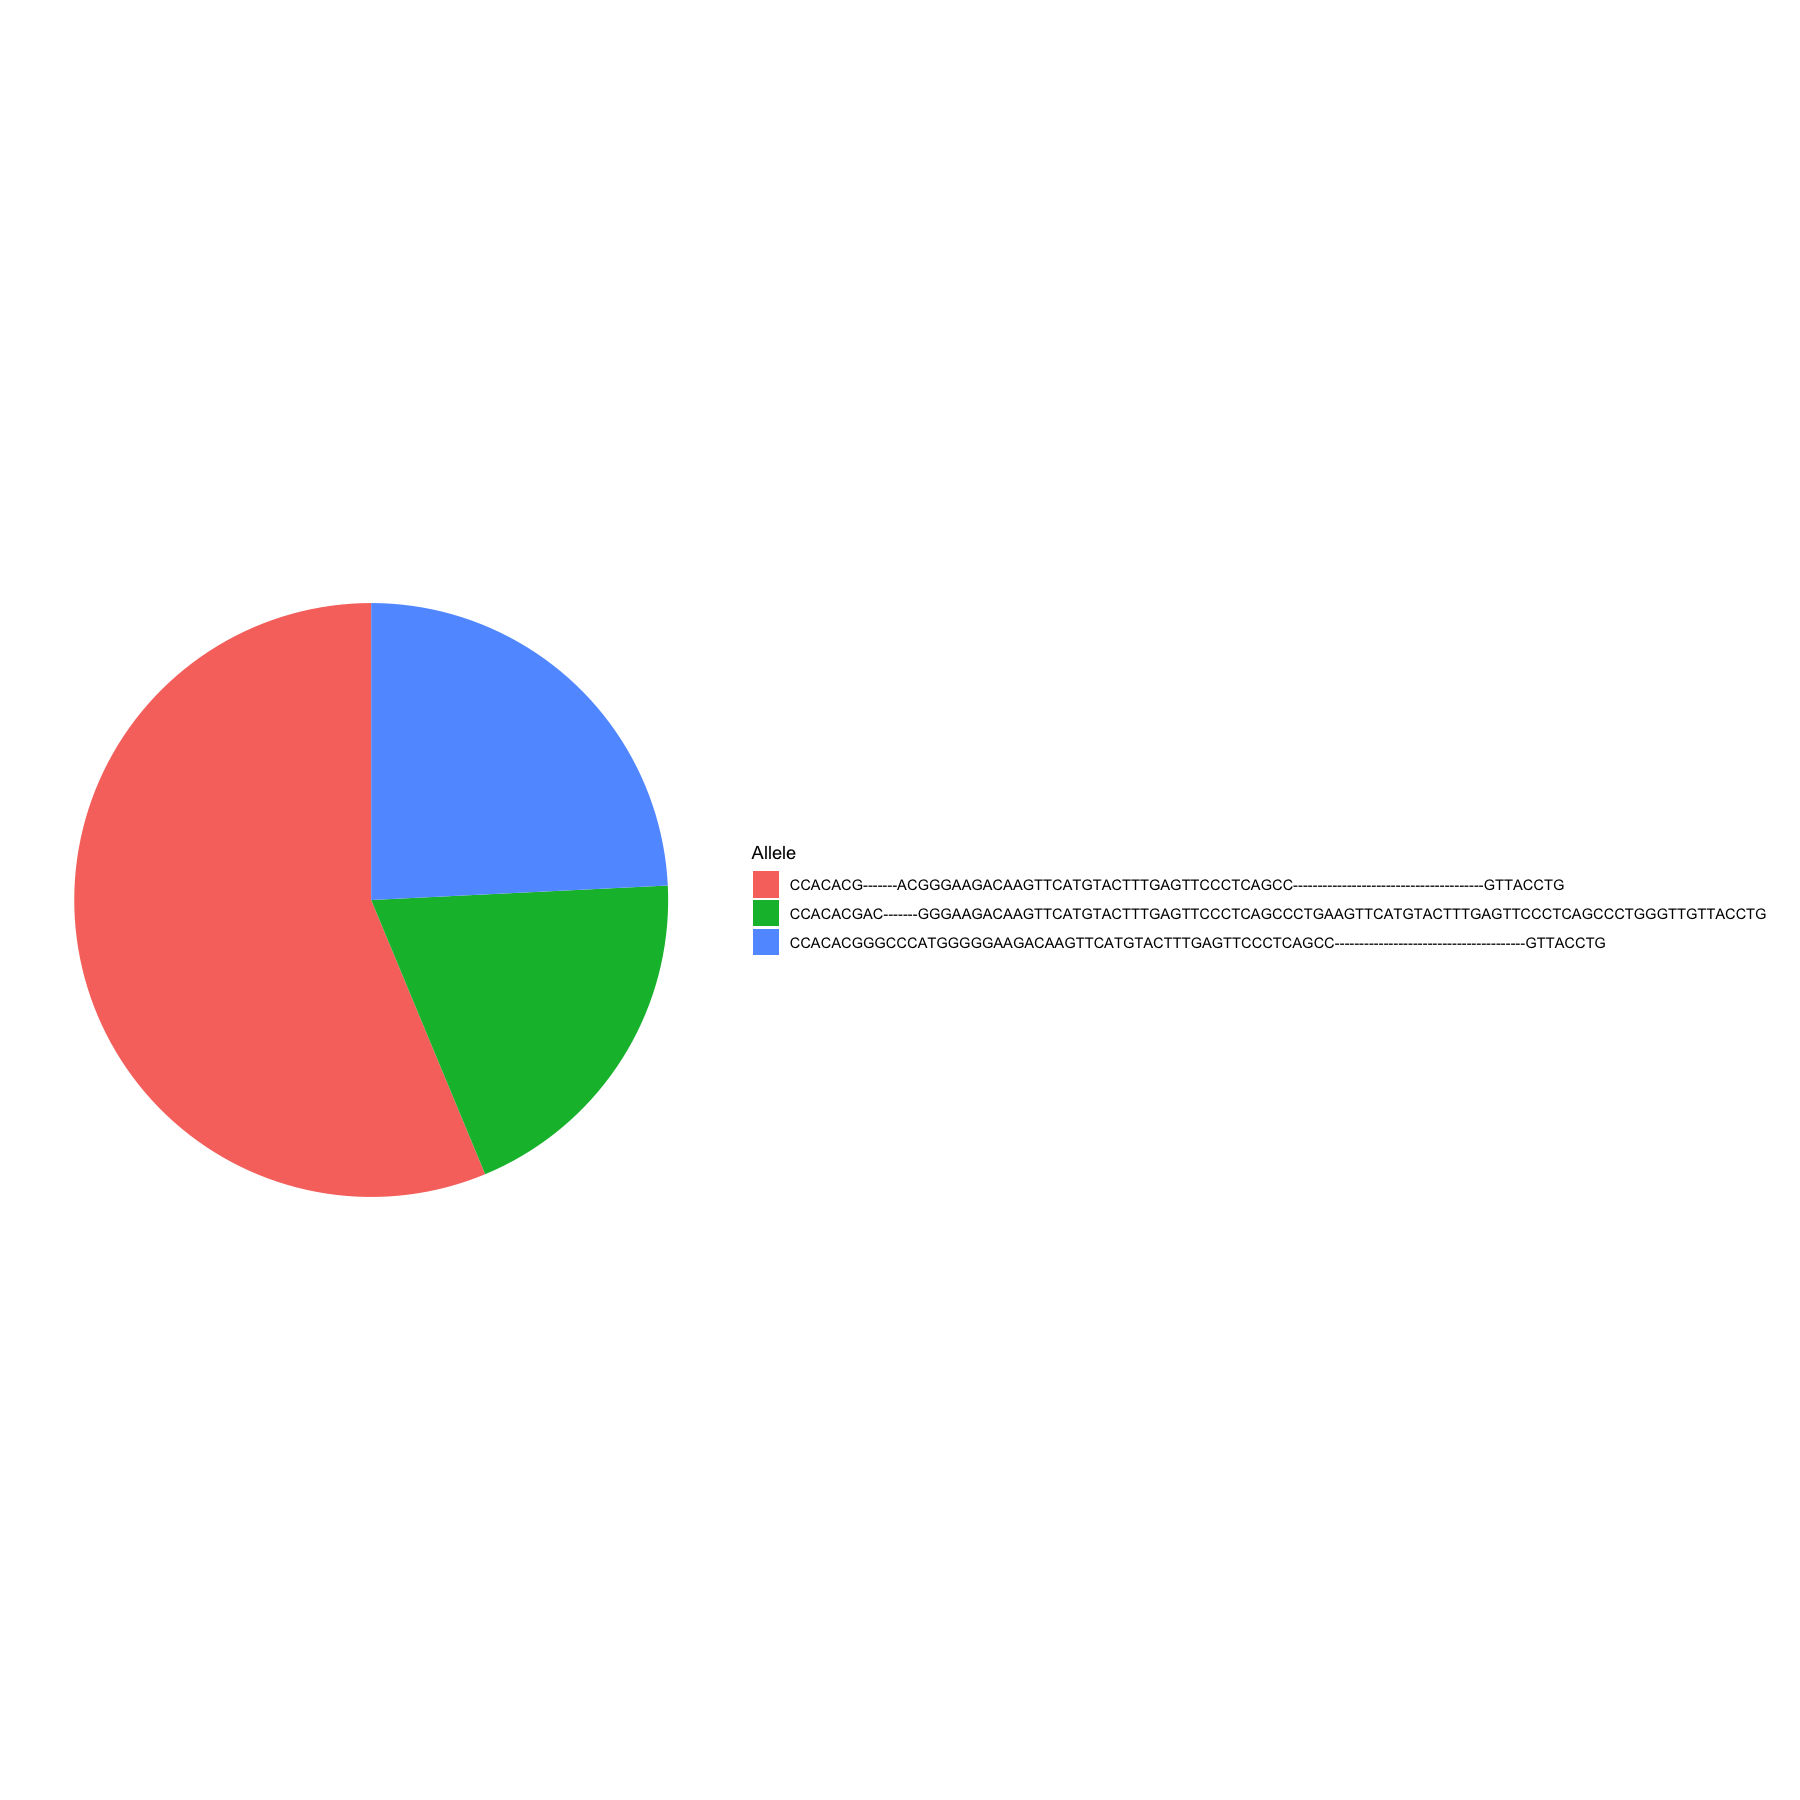

In [39]:
#Let's look at all these alleles. 
fig.size(15,15)
PTENp1_filtered_3_align$Aligned_Sequence %>% table %>% as_tibble() %>% ggplot(aes(x="", y=`n`, fill=as.factor(`.`))) +
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0) + theme_void() + labs(fill = "Allele")

## Calling genotypes

In [40]:
#Identify all alleles present in this data. 
Genotypes <- PTENp1_filtered_2_align$Aligned_Sequence %>% unique

In [41]:
#Collapse the values of all alleles detected into one string.
PTENp1_genotypes <- PTENp1_filtered_2_align %>% group_by(plate_well) %>% arrange(Aligned_Sequence) %>% summarize(genotype = str_c(Aligned_Sequence, collapse ="_"))

In [42]:
#merge with full data on cell identity
PTENp1_genotypes<- PTENp1_genotypes %>% left_join(unique(distinct(PTENp1_filtered_2_align, Barcode_DNA, Well_ID, plate_well))) %>% 
    inner_join(read_csv("2023-04-03 PTEN-DQB1-FBXO11/Analysis/PTENplots2.csv"), by = c("Barcode_DNA", "Well_ID")) 

Joining with `by = join_by(plate_well)`
Rows: 510 Columns: 35
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (19): Well_ID, DNA_Barcode, RNA_Barcode, Experiment_Index, Plate, FBXO11...
dbl (16): PB_CD45, BV605_CD45, SSC, FSC, FITC_DQB1, PE_CD40, PECY7_CD45, APC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [43]:
#Add genotype ID for later deconvolution
PTENp1_genotypes<- PTENp1_genotypes %>% 
mutate(AllelicGenotype = 
       paste(ifelse(grepl(genotype.x, pattern = fixed(Genotypes[1])),"A",""),
             ifelse(grepl(genotype.x, pattern = fixed(Genotypes[2])),"B",""),
             ifelse(grepl(genotype.x, pattern = fixed(Genotypes[3])),"C",""), sep=""))

Warning message:
“`as_data_frame()` was deprecated in tibble 2.0.0.
ℹ Please use `as_tibble()` (with slightly different semantics) to convert to a tibble, or `as.data.frame()` to convert to a data frame.”


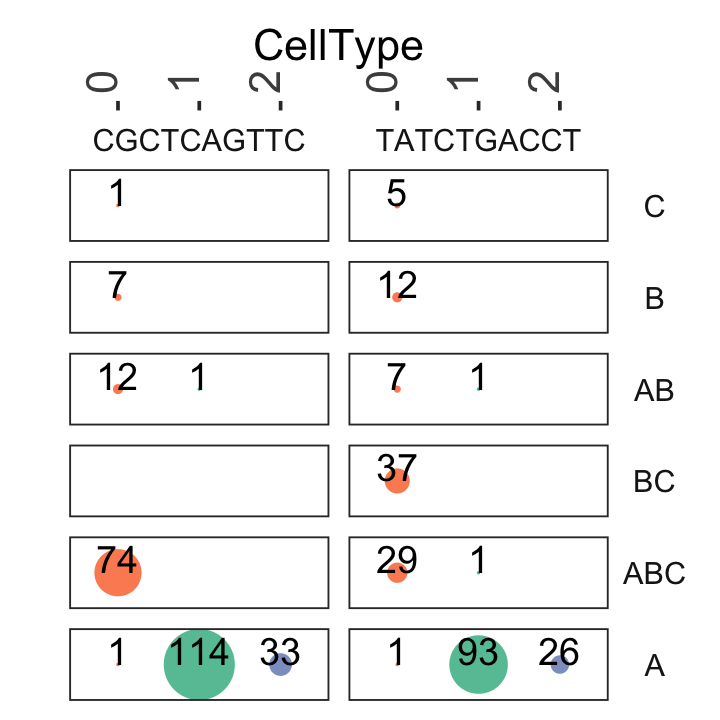

In [44]:
## Plot of PTEN genotypes distributions across RNA clusters
## Define df for plotting 
test2 <- PTENp1_genotypes %>% add_count(genotype.x,name = "genotype_count") %>% 
    filter(genotype_count  > 2)

#Defineplotting Order
order <- test2$AllelicGenotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)


fig.size(6,6)
g <- 

table(test2$AllelicGenotype,test2$cluster.x, test2$Barcode_DNA) %>% 
as.data.frame() %>% dplyr::rename(CellType = Var2, genotype = Var1, Plate = Var3) %>% 
na.omit %>% filter(Freq != 0) %>% {
    
    ggplot(., aes(CellType,fill=CellType,
                   size = Freq)) +
      geom_point(aes(y = 0),shape = 21, stroke = 0) +
      #geom_hline(yintercept = seq(.5, 4.5, 1), size = .2) +
  scale_x_discrete(position = "top") +
  scale_radius(range = c(1,20)) +
    geom_text(aes(y = 0, label = Freq), size =8, vjust = -0)+
  theme_gy() +
  theme(legend.position = "none", 
        panel.grid.major = element_blank(),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8), 
       axis.text.x = element_text(angle = 90)) + 
    ylab("") + 
    scale_y_discrete(expand = c(0.1,0.5)) + 
    facet_grid(factor((genotype), levels = order)~ Plate) + 
    theme(
  strip.background = element_blank(),
  #strip.text.x = element_blank(), 
    #panel.border=element_blank(), 
  strip.text.y = element_text(angle = 0) 
        ) +scale_fill_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62')) 
    
} 
plot(g)
#suppressWarnings({ 
 #   ggsave(g, filename = "PTEN_Genotypes.png", device = "png", dpi = 300, width = 3, height = 6)
  #  })

## Plotting the genotypes. For each genotype plot sequence. 

In [45]:
PlottingGenotypes <- select(PTENp1_filtered_3_align, Aligned_Sequence, Reference) %>% unique() %>% as_tibble()

In [46]:
PlottingGenotypes

Aligned_Sequence,Reference
<chr>,<chr>
CCACACG-------ACGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCC---------------------------------------GTTACCTG,CCACACGGGCCCATGGGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTG
CCACACGGGCCCATGGGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCC---------------------------------------GTTACCTG,CCACACGGGCCCATGGGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTG
CCACACGAC-------GGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTG,CCACACGGGCCCATGGGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTG


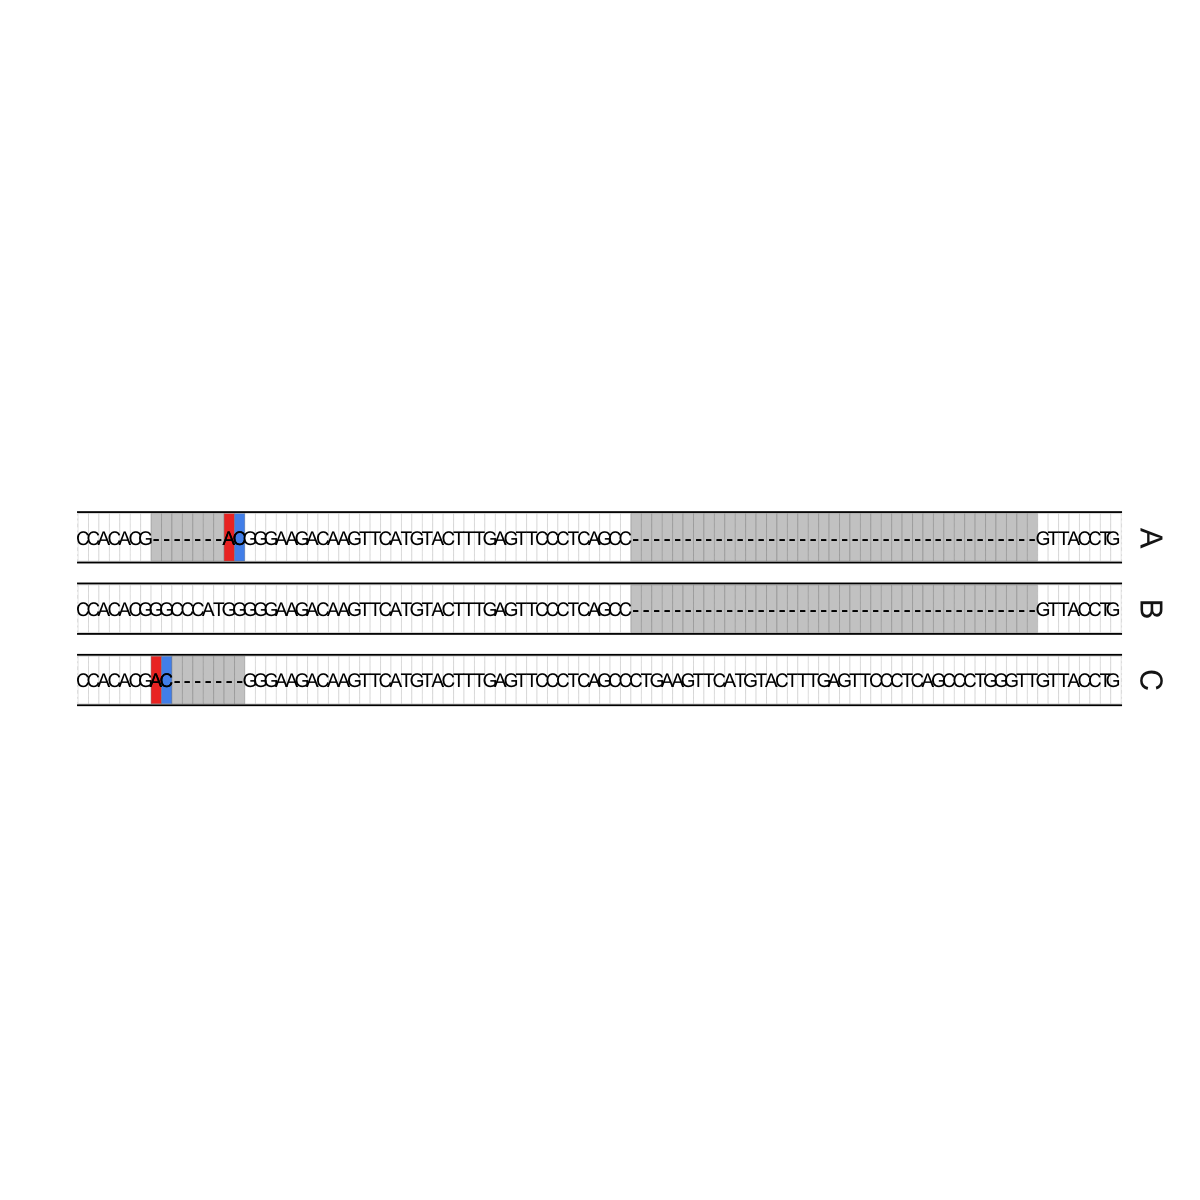

In [47]:
#Plot these sequences with custom scripts. 


    CRISPRessoDNA_heatmap <- PlottingGenotypes 
    ALLELES <- apply(matrix(CRISPRessoDNA_heatmap$Aligned_Sequence), 1, 
        function(x) {
            gsub("(.{1})", "\\1 ", x)
        }) %>% str_split_fixed(pattern = " ", n = str_length(CRISPRessoDNA_heatmap$Aligned_Sequence[1]))
    REF <- apply(matrix(CRISPRessoDNA_heatmap$Reference), 1, 
        function(x) {
            gsub("(.{1})", "\\1 ", x)
        }) %>% str_split_fixed(pattern = " ", n = str_length(CRISPRessoDNA_heatmap$Reference[1]))

    x <- copy(ALLELES)
    x[ALLELES == REF] <- "R"
    y <- copy(ALLELES)
    x <- x %>% unique %>% as.data.frame(stringsAsFactors = FALSE) %>% 
        tidyr::gather(position, value) %>% dplyr::mutate(position = gsub("V", 
        "", position))
    y <- y %>% unique %>% as.data.frame(stringsAsFactors = FALSE) %>% 
        rownames_to_column("genotypes") %>% tidyr::gather(position, 
        value, -genotypes) %>% dplyr::mutate(position = gsub("V", 
        "", position))
    x <- mutate(x, genotypes = y$genotypes)
    y <- y %>% dplyr::rename(label = value)
    x <- x %>% cbind(y$label)
    x <- mutate(x, genotypes = LETTERS[as.numeric(genotypes)])

fig.size(10,10)
   g<- x %>% #the number is the filter on genotype 
ggplot(aes(x = reorder(position, as.integer(position)), 
           y = 1, fill = `value`)) + 
    geom_tile(aes(color = value), width=1, height=1) +
        geom_text(data = dplyr::filter(x),
                  aes(label = `y$label`), angle = 0, size = (4)) + 
        geom_text(data = dplyr::filter(x, value != "R"),
                  aes(label = `y$label`), angle = 0, size = (4))+
        scale_fill_manual(values = 
                    c(R = 'white',
                    C = "#5194ed", 
                      T = "#fdb462", 
                      G = "#7fc97f", 
                      A = "#ef3b2c",
                     `-` ="grey80"))+ 
        scale_color_manual(values = 
                   c(R = 'grey'))+
 
     #c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33"))
        ggtitle("") + 
        theme_gy()+
    xlab("")+
    theme(aspect.ratio = 0.05)+ 
    ylab("") +
    theme(axis.text.y = element_text(size = 0, angle = 0, hjust = .5, vjust = .5),
          axis.text.x = element_text(size = 0),
        axis.title.x = element_text(size = 20, angle = 0, hjust = .5, vjust = .5),
        axis.title.y = element_text(size = 20, angle = 90, hjust = .5, vjust = .5),
          axis.ticks.y = element_blank(),
         legend.position = "none") + 
    scale_x_discrete(breaks=NULL) + 
    facet_grid(factor((genotypes),)~.)+ 
theme(
  strip.background = element_blank(),
  strip.text.x = element_blank(), 
    panel.border=element_blank()

) + 
    annotate(geom = 'segment', y = Inf, yend = Inf, color = 'black', x = -Inf, xend = Inf, size = 1) + 

    annotate(geom = 'segment', y = -Inf, yend = -Inf, color = 'black', x = -Inf, xend = Inf, size = 1)
plot(g)


In [ ]:
## This has been standardized into some key fuction below

In [49]:
Filtering_Cells_Read # filtering cells by read per plate

function(x){ 
mat <- mutate(x, plate_well =  paste0(Barcode_DNA, Well_ID)) # add platt_well id. The input are allele tables output and combined from CRISPEsso (keeping the top 10)
mat <- mutate(mat, TotalReads = `#Reads`/(`%Reads`/100))# Calculate total reads
Plates <- unique(mat$Barcode_DNA) # Define the plate
 
#To plate we will now identify plate cutoffs of total reads based on ranking. 
ReadFilters <- 
    lapply(Plates, 
    function(Plate){
    data <- mat %>% filter(Barcode_DNA == Plate) %>% group_by(plate_well) %>% top_n(1, wt = `#Reads`) %>% select(TotalReads, plate_well) %>% unique #Total reads per cell are extracted. 
    totals <-data$TotalReads #This data is defined
    o <- order(totals, decreasing = T) # find the order
    stuff <- rle(totals[o]) # handling ties
    run.totals <- stuff$values # pull out values
    run.rank <- cumsum(stuff$lengths) - (stuff$lengths-1)/2 # Get mid-rank of each run.

    y <- log10(run.totals) #Define y as log10 transformed reads / cell
    x <- (run.rank) # Rank with ties

    fit <- smooth.spline(x, y, df=5) # Fit a spline with 5 degrees of freedom. Have tested more - up to 20. Leads to instability. 
    d1 <- predict(fit, deriv=1)$y #first derivative 
    d2 <- predict(fit, deriv=2)$y #second derivative
    curvature <- d2/(1 + d1^2)^1.5 # predict curvature - This is from the Empty Droplets Algorithm paper. 
    
    #Plot curvature and cutoff. 
    print(ggplot(data = tibble(x = 1:length(curvature), y=curvature), aes(x,y)) + geom_point()+ xlab("Rank") + ylab("Calculated Curvature") + theme_gy() + 
          theme(axis.text.x = element_text(hjust = 0.75)) + ggtitle(Plate) + 
          geom_vline(xintercept = which.min(curvature),linetype= "dashed", color = "red", size = 1)) # A graph of the total reads with cutoff labelled, sanity check.  
    
    #A graph of the total reads with cutoff labelled, sanity check. 
    print(ggplot(data = tibble(x,y), aes(x,y)) + geom_point()+ xlab("Rank") + ylab("log10(Reads) \n per cell") + theme_gy() + theme(axis.text.x = element_text(hjust = 0.75)) + ggtitle(Plate) + 
        geom_hline(yintercept = y[which.min(curvature)],linetype= "dashed", color = "red", size = 1))
    
    return(cutoff = 10^y[which.min(curvature)]) # store this cutoff
    })
    names(ReadFilters) <- Plates # add plate name

    #Filter plates and return combined tibble. 
return(
    bind_rows(lapply(Plates, function(x){
    filter(mat, Barcode_DNA == x & TotalReads > ReadFilters[x])})))
    }
<bytecode: 0x3247bb698>

In [48]:
Filtering_Alleles #filtering alleles per cell and with a threshold

function (x, cutoff = 10) 
{
    matrix <- x
    matrix <- mutate(matrix, plate_well = paste0(Barcode_DNA, 
        Well_ID))
    cells <- unique(matrix$plate_well)
    Plates <- unique(matrix$Barcode_DNA)
    Allele_Threshold <- lapply(cells, function(x) {
        data <- matrix %>% filter(plate_well == x) %>% dplyr::select(`%Reads`)
        totals <- data$`%Reads`
        o <- order(totals, decreasing = T)
        stuff <- rle(totals[o])
        run.totals <- stuff$value
        run.rank <- cumsum(stuff$lengths) - (stuff$lengths - 
            1)/2
        y <- log10(run.totals)
        x <- (run.rank)
        return(which.min(diff(y)/diff(x)))
    })
    names(Allele_Threshold) <- cells
    Allele_Threshold <- lapply(Allele_Threshold, function(x) ifelse(length(x) == 
        0, 1, x))
    Filter_matrix <- bind_rows(lapply(cells, function(x) {
        if ((Allele_Threshold[x] > 0) == T) {
            dplyr::filter(matrix, plate_well == x) %>% top_n(n = Allele_Threshold[x], 
                wt = `%Reads`)
        }
        else {
            dplyr::filter(matrix, plate_well == x) %>% top_n(n = 1, 
                wt = `%Reads`)
        }
    }))
    Filter_matrix <- dplyr::filter(Filter_matrix, `%Reads` >= 
        cutoff)
    return(Filter_matrix)
}

In [50]:
Genotyping_Cells # calling genotypes

function (x) 
{
    matrix <- x
    Genotypes <- matrix$Aligned_Sequence %>% unique
    matrix_genotypes <- matrix %>% group_by(plate_well) %>% arrange(Aligned_Sequence) %>% 
        summarize(genotype = str_c(Aligned_Sequence, collapse = "_"))
    matrix_genotypes <- mutate(matrix_genotypes, AllelicGenotype = "")
    for (i in 1:length(Genotypes)) {
        matrix_genotypes <- mutate(matrix_genotypes, AllelicGenotype = str_c(AllelicGenotype, 
            ifelse(grepl(genotype, pattern = fixed(Genotypes[i])), 
                LETTERS[i], "")))
    }
    return(matrix_genotypes)
}

In [51]:
Plotting_Alleles # plotting alleles

function (Filter_Allele_Tibble) 
{
    UniqueAlleles <- select(Filter_Allele_Tibble, Aligned_Sequence, 
        Reference) %>% unique() %>% as_tibble()
    ALLELES <- apply(matrix(UniqueAlleles$Aligned_Sequence), 
        1, function(x) {
            gsub("(.{1})", "\\1 ", x)
        }) %>% str_split_fixed(pattern = " ", n = str_length(UniqueAlleles$Aligned_Sequence[1]))
    REF <- apply(matrix(UniqueAlleles$Reference), 1, function(x) {
        gsub("(.{1})", "\\1 ", x)
    }) %>% str_split_fixed(pattern = " ", n = str_length(UniqueAlleles$Reference[1]))
    x <- copy(ALLELES)
    x[ALLELES == REF] <- "R"
    y <- copy(ALLELES)
    x <- x %>% unique %>% as.data.frame(stringsAsFactors = FALSE) %>% 
        tidyr::gather(position, value) %>% dplyr::mutate(position = gsub("V", 
        "", position))
    y <- y %>% unique %>% as.data.frame(stringsAsFactors = FALSE) %>% 
        rownames_to_column("genotypes") %>% tidyr::gather(position, 
        value, -genotypes) %>% dplyr::mutate(position = gsub("V", 
        "", position))
    x <- mutate(x, genotypes = y$genotypes)
    y <- y %>% dplyr::rename(label = value)
    x <- x %>% cbind(y$label)
    x <- mutate(x, genotypes = LETTERS[as.numeric(genotypes)])
    fig.size(10, 10)
    g <- x %>% ggplot(aes(x = reorder(position, as.integer(position)), 
        y = 1, fill = value)) + geom_tile(aes(color = value), 
        width = 1, height = 1) + geom_text(data = dplyr::filter(x), 
        aes(label = `y$label`), angle = 0, size = (4)) + geom_text(data = dplyr::filter(x, 
        value != "R"), aes(label = `y$label`), angle = 0, size = (4)) + 
        scale_fill_manual(values = c(R = "white", C = "#5194ed", 
            T = "#fdb462", G = "#7fc97f", A = "#ef3b2c", `-` = "grey80")) + 
        scale_color_manual(values = c(R = "grey")) + ggtitle("") + 
        theme_gy() + xlab("") + theme(aspect.ratio = 0.1) + ylab("") + 
        theme(axis.text.y = element_text(size = 0, angle = 0, 
            hjust = 0.5, vjust = 0.5), axis.text.x = element_text(size = 0), 
            axis.title.x = element_text(size = 20, angle = 0, 
                hjust = 0.5, vjust = 0.5), axis.title.y = element_text(size = 20, 
                angle = 90, hjust = 0.5, vjust = 0.5), axis.ticks.y = element_blank(), 
            legend.position = "none") + scale_x_discrete(breaks = NULL) + 
        facet_grid(factor((genotypes), ) ~ .) + theme(strip.background = element_blank(), 
        strip.text.x = element_blank(), panel.border = element_blank()) + 
        annotate(geom = "segment", y = Inf, yend = Inf, color = "black", 
            x = -Inf, xend = Inf, size = 1) + annotate(geom = "segment", 
        y = -Inf, yend = -Inf, color = "black", x = -Inf, xend = Inf, 
        size = 1)
    return(g)
}